Model Building 

In [13]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
#  change current directory to directory data file is located

import os
os.chdir('/content/drive/My Drive/DataHacker/DS_HK/Dataset')

In [46]:
#  importing various packages for model building and tunning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.metrics import precision_recall_curve
from joblib import load,dump
from sklearn import metrics
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
% matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
#  read training data
train_df = pd.read_csv('Train.csv',parse_dates=['DATE'])

Note : While doing EDA we conclude that INCIDENT_ID and DATE will not contribute any meaning for model training as INCIDENT_ID is the Ticket raised for hacked server and Date is the incident date , but we have proper info about the feature of X_1- X_15 , then we can used that date column to analys whether server get hacked on same day/month,  or they are following some pattern , or may be they are attacking server while doing some maintaince.

Note: We need to drop INCIDENT_ID and DATE

In [35]:
"""
preprocessing_data function : 

It deals with dropping unneccessary columns , filling missing values with its 
median value 

Argument : 
data = Input DataFrame
file_type = default: train  , test

Return : 
X : Independent data
y : Target value
output_file : file for submission

"""


def preprocessing_data(data,file_type = 'train'):
  
  #  initializing X , y, output_file with None
  X = None
  y = None
  output_file = None
  file_type  = file_type.lower()
  
  #  Saving incident id in outputfile for submission data
  if file_type == 'test':
    output_file = pd.DataFrame()
    output_file['INCIDENT_ID'] = data.INCIDENT_ID

  #  dropping INCIDENT_ID and Date column
  data.drop(columns = ['INCIDENT_ID','DATE'],inplace = True)
  
  #  replacing missing values with median values
  data.X_12.fillna(data.X_12.median(),inplace = True)
  data.X_12 = data.X_12.astype('int64')

  #  separating X (independent) and y (dependent) 
  if file_type == 'train':
    y = data.MULTIPLE_OFFENSE
    X = data.drop(columns=['MULTIPLE_OFFENSE'])

  return X , y , output_file 

In [18]:
#  spilitting Training and Testing data

from sklearn.model_selection import train_test_split

X, y , _ = preprocessing_data(train_df)
x_train,x_val,y_train,y_val = train_test_split(X,y,train_size=0.8,shuffle=True,)


#  define folds for training
str_fold = StratifiedKFold()

In [19]:
"""
hyperpara_tunner:

This function will tune hyper parameter of model:

Argument :
model = object of model
param = parameter to be tune
model_name = to save model with given name
x = training independent data
y = target variable

Return : 
hist = all traning data
best_eestimator_ = best model
"""

def hyperpara_tunner(model ,param , model_name, x = x_train , y = y_train ):
  random = RandomizedSearchCV(estimator = model, param_distributions = param , n_iter = 10,scoring = 'recall',n_jobs =-1,
                              cv = str_fold)
  hist = random.fit(x,y)
  dump(hist.best_estimator_,f"{model_name}.sav")
  return hist , hist.best_estimator_

In [20]:
"""
pr_threshold function :

This function will plot precision v/s recall 

Argument:

model = model object
x = x test/val
y = y test/val

"""

def pr_threshold(model,x = x_val , y = y_val):
  #  calculate precision recall curve
  precision, recall, thresholds = precision_recall_curve(y, model.predict_proba(x)[:,1])
  plt.title("Precision-Recall vs Threshold Chart")
  plt.plot(thresholds, precision[: -1], "b--", label="Precision")
  plt.plot(thresholds, recall[: -1], "r--", label="Recall")
  plt.ylabel("Precision, Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="lower left")
  plt.ylim([0,1])
  plt.show()

In [21]:
"""
roc_plot :

This function will plot ftr and tpr values i.e ROC (region of convergance) or AUC (Area under curve)
which will help to identify which threshold to be used

Argument:

model = model object
x = x test/val
y = y test/val

"""

def roc_plot(model,x = x_val , y = y_val):
  # calculate roc curves
  fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(x)[:,1]) 
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Xgboost')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()

In [22]:
"""
gplot:

This function will plot highest threshold point on the roc_curve

Argument:

model = model object
x = x test/val
y = y test/val

"""
def gplot(model,x = x_val, y = y_val):
  # calculate roc curves
  fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(x)[:,1]) 
  #calculate the g-mean for each threshold
  gmeans = np.sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)
  print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Xgboost')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()

In [23]:
"""

best_threshold 

This function will find the best threshold to make target 1 or 0

Argument:

model = model object
x = x test/val
y = y test/val

Return :

best_thresh

"""

def best_threshold(model,x = x_val, y = y_val):
  # calculate roc curves
  fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(x)[:,1]) 
  # get the best threshold
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  return best_thresh

In [60]:
"""
submission_file

This function will produce output file

"""

def submission_file(model,path):

  #  read test file
  x_test = pd.read_csv(path+'Test.csv')

  #  preprocess test data
  output_file = pd.DataFrame()
  output_file['INCIDENT_ID'] = x_test['INCIDENT_ID']
  x_test.drop(columns=['DATE','INCIDENT_ID'],inplace=True)
  
  #  get best threshold
  threshold = best_threshold(model)

  #predict output
  y_pred = model.predict_proba(x_test)[:,1]
  y_pred = binarize(y_pred.reshape(-1,1),threshold)

  #  save output to file
  output_file['MULTIPLE_OFFENSE'] = y_pred

  #  save output file
  output_file.to_csv('final_submission.csv',index=False)


In [25]:
#  XGboost Model
classifier = xgb.XGBClassifier()

In [26]:
# hyper parameter to be tunned
params = {
    'learning_rate' : [0.1,0.001,0.01],
    'max_depth': range(3,11,2),
    'min_child_weight' : [1,2,3,5],
    'lamdba':[0.5,1,2,0.2,0.3],
    'gamma':[0.1,0.2,0.3],
    'scale_pos_weight' : [1,3,2,0.5],
    'subsample':[0.5,1],
    'n_estimators':[5000],
    'early_stopping_rounds':[5],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9 ],
    'num_boost_round' :[999]
}

In [27]:
hist , best_model = hyperpara_tunner(classifier,params,'xgb_model',x_train,y_train)

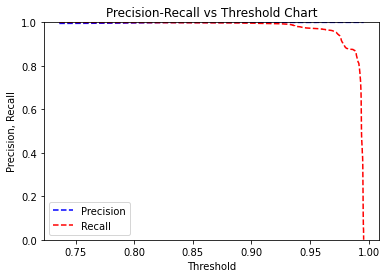

In [47]:
pr_threshold(best_model)

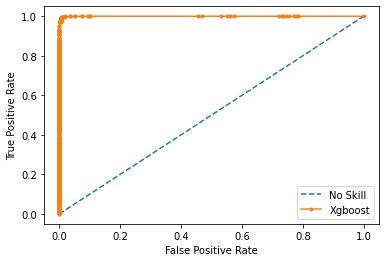

In [48]:
roc_plot(best_model)

Best Threshold=0.901092, G-Mean=0.996


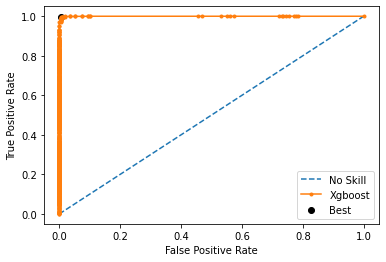

In [49]:
gplot(best_model)

In [50]:
best_threshold(best_model)

Best Threshold=0.901092


0.90109223

In [61]:
# generate outputfile
#model = load('/content/drive/My Drive/DataHacker/DS_HK/Dataset/xgb_model.sav')
path = '/content/drive/My Drive/DataHacker/DS_HK/Dataset/'
submission_file(best_model,path)

Best Threshold=0.901092
